In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
eur_usd_df = pd.read_csv('^eurusd_daily_historical-data-09-30-2020.csv', index_col = [0], parse_dates = [0])
eur_usd_df = eur_usd_df.iloc[:-1,:]
eur_usd_df = eur_usd_df[::-1]
print('Shape of the dataframe: ', eur_usd_df.shape)
eur_usd_df.head()

Shape of the dataframe:  (5384, 6)


,Open,High,Low,Last,Change,Volume
Time,,,,,,
01/03/2000,1.0085,1.0280,1.0055,1.0256,0.0168,0.0
01/04/2000,1.0255,1.0340,1.0217,1.0301,0.0045,0.0
01/05/2000,1.0304,1.0400,1.0289,1.0315,0.0014,0.0
01/06/2000,1.0320,1.0413,1.0283,1.0315,0.0000,0.0
01/07/2000,1.0317,1.0333,1.0263,1.0296,-0.0019,0.0


In [3]:
eur_usd_df.index = pd.DatetimeIndex(data = eur_usd_df.index)
eur_usd_df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Time', length=5384, freq=None)

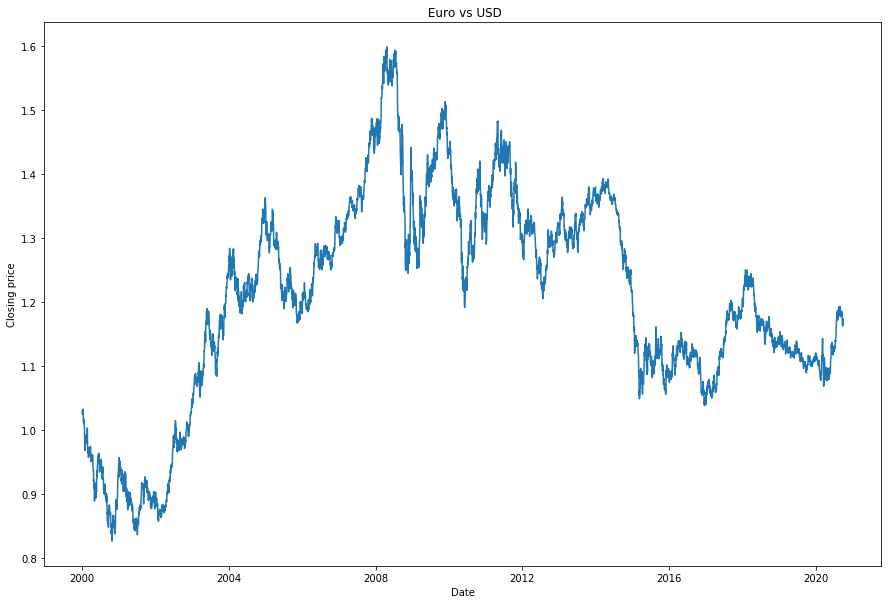

In [4]:
plt.figure(figsize = (15,10))
plt.plot(eur_usd_df['Last'])
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.title(' Euro vs USD')
plt.show()

A given time series consists of systematic components like level, trend, seasonality and non-systematic component called noise
* __Level__: The average value in series.
* __Trend__: The increasing or decreasing value in the series
* __Seasonality__: The repeating short-term cycle in the series
* __Noise__: The random variation in the series

The time series analysis works very well on stationary data, hence we need to verify if the data is stationary.

### ADF (Augmented Dickey-Fuller Test)

This is a statistical test used to determine the presence of unit root in the series, and it helps us understand if the series is stationary or not.

__Null hypothesis__: concludes the series has a unit root (value of a = 1)
__Alternate hypothesis__: conclude the series has no unit root

If we fail to reject the null hypothesis, we can say that the series is non-stationary. 
Alternatively if the rolling mean and standard mean do not change with time, it also means the data is stationary.

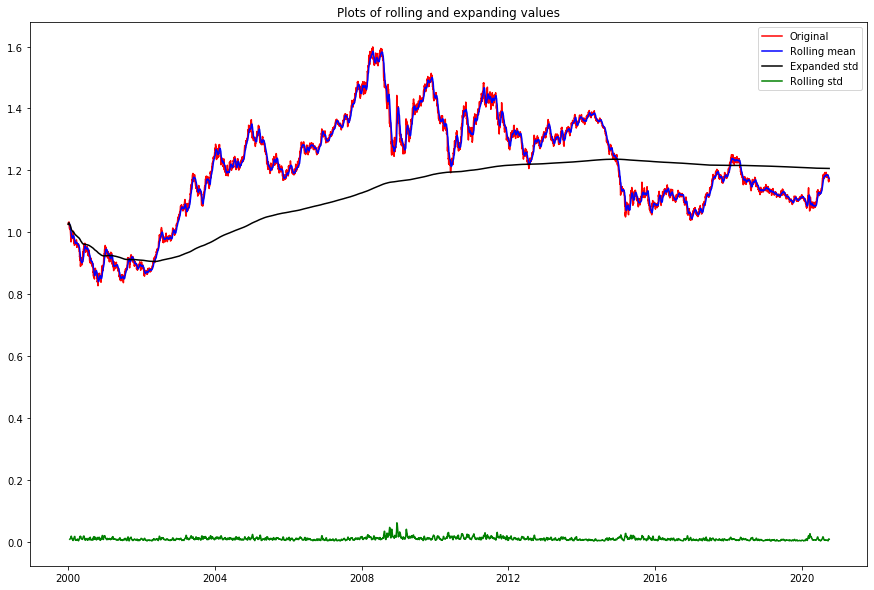

In [5]:
rolling_mean = eur_usd_df['Last'].rolling(window = 12).mean()
rolling_std = eur_usd_df['Last'].rolling(window = 12).std()
expanded_mean = eur_usd_df['Last'].expanding().mean()
plt.figure(figsize = (15,10))
plt.plot(eur_usd_df['Last'], color = 'red', label = 'Original')
plt.plot(rolling_mean, color = 'blue', label = 'Rolling mean')
plt.plot(expanded_mean, color = 'black', label = 'Expanded std')
plt.plot(rolling_std, color = 'green', label = 'Rolling std')
plt.title('Plots of rolling and expanding values')
plt.legend()
plt.show()

In [6]:
dicker_fuller_results = adfuller(x = eur_usd_df['Last'],
                                 autolag = 'AIC')
print('Test statistics: ', dicker_fuller_results[0])
print('p-value: ', dicker_fuller_results[1])
print('Number of lags used : ', dicker_fuller_results[2])
print('Number of observations used : ', dicker_fuller_results[3])
for keys, values in dicker_fuller_results[4].items():
    print('critical value ({}%):  {}'.format(keys, values))

Test statistics:  -1.8074802742310678
p-value:  0.376754320140034
Number of lags used :  0
Number of observations used :  5383
critical value (1%%):  -3.4315653856728168
critical value (5%%):  -2.8620770774534745
critical value (10%%):  -2.567055885533713


* Based on the plots the rolling mean is not constant, it is changing with time, hence based on this it is not stationary
* From dickey fuller test, the p value is 0.37, in order to reject the null hypothesis, the p value had to be lower than 0.05
* Also the test statistics is greater than the critical values, hence the data is not stationary

In order to perform time series analysis, we need to seperate seasonality and trend from the series.

<Figure size 432x288 with 0 Axes>

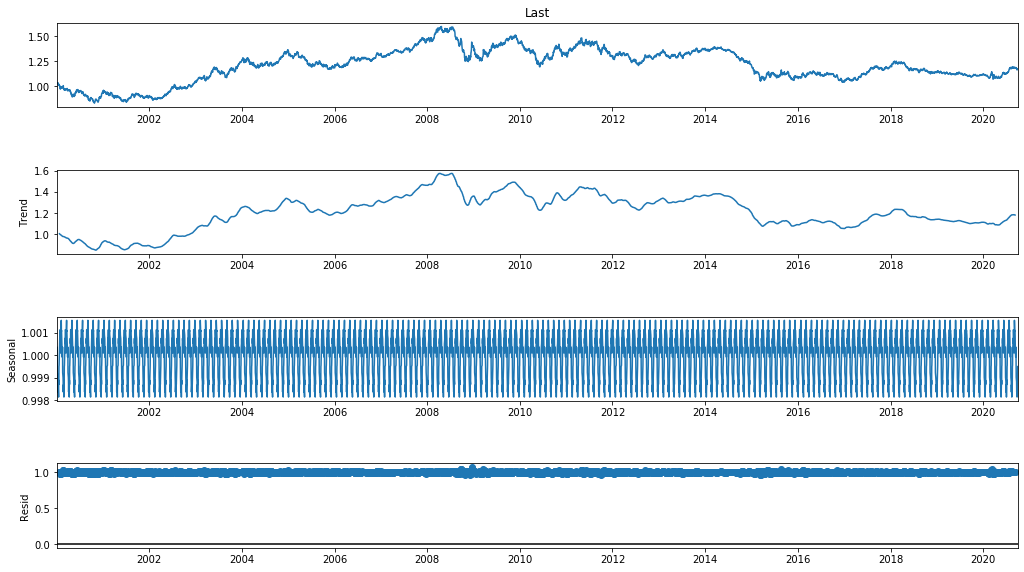

In [7]:
seasonal_result = seasonal_decompose(x = eur_usd_df['Last'],
                                     model = 'multiplicative',
                                     freq = 30)
figure = plt.figure()
figure = seasonal_result.plot()
figure.set_size_inches(16, 9)

### Make data stationary

* function to make transformations

In [8]:
def transform_data_results(data):
    rolling_mean = data.rolling(window = 12).mean()
    rolling_std = data.rolling(window = 12).std()
    expanded_mean = data.expanding().mean()
    plt.figure(figsize = (15,10))
    plt.plot(rolling_mean, color = 'blue', label = 'Rolling mean')
    plt.plot(expanded_mean, color = 'black', label = 'Expanded std')
    plt.plot(rolling_std, color = 'green', label = 'Rolling std')
    plt.title('Plots of rolling and expanding values')
    plt.legend()
    plt.show()
    
    dicker_fuller_results = adfuller(x = data,
                                     autolag = 'AIC')
    print('Dickey fuller results')
    print('Test statistics: ', dicker_fuller_results[0])
    print('p-value: ', dicker_fuller_results[1])
    print('Number of lags used : ', dicker_fuller_results[2])
    print('Number of observations used : ', dicker_fuller_results[3])
    for keys, values in dicker_fuller_results[4].items():
        print('critical value ({}%):  {}'.format(keys, values))

* TRANSFORMATION with log data

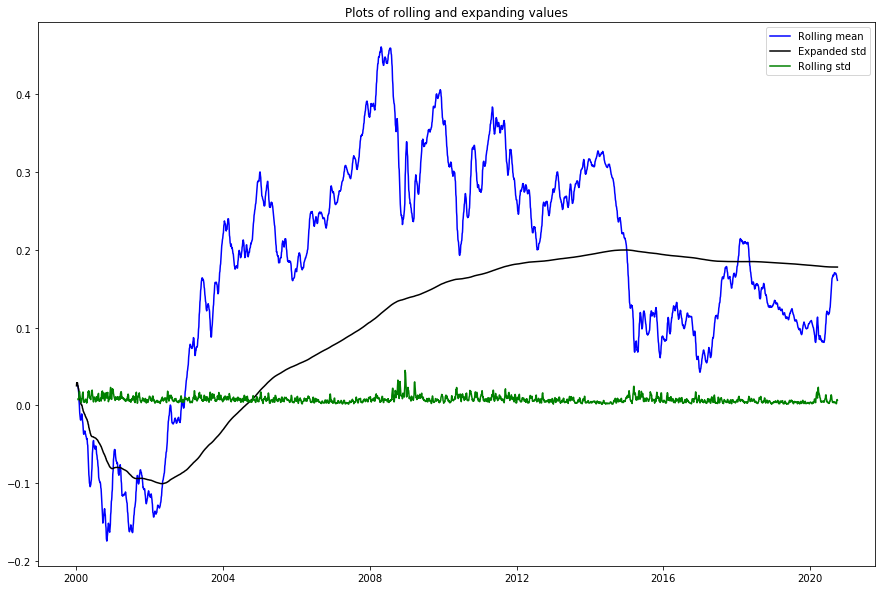

Dickey fuller results
Test statistics:  -1.7443786525990803
p-value:  0.4084043815394185
Number of lags used :  0
Number of observations used :  5383
critical value (1%%):  -3.4315653856728168
critical value (5%%):  -2.8620770774534745
critical value (10%%):  -2.567055885533713


In [9]:
log_data = np.log(eur_usd_df['Last'])
transform_data_results(log_data)

* TRANSFORMATION with 5 days Moving average of log data

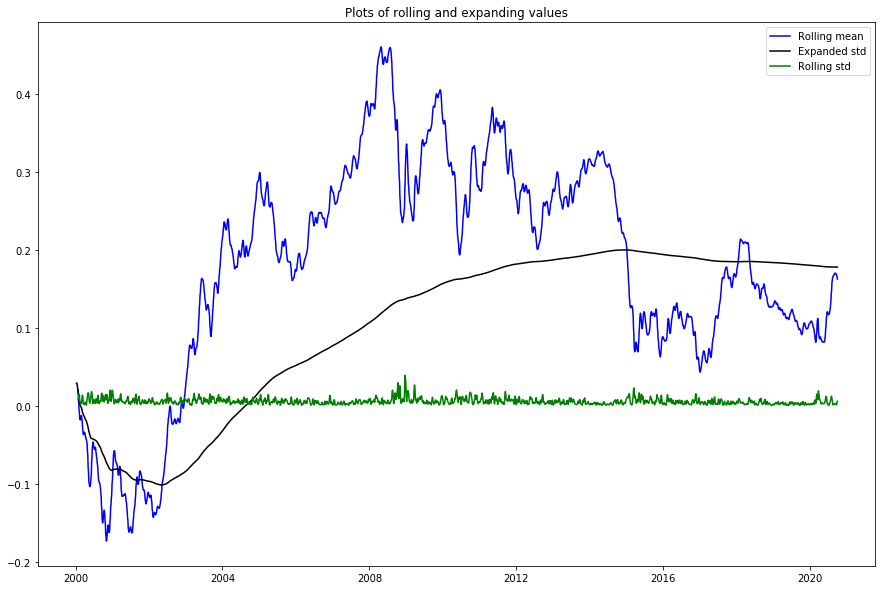

Dickey fuller results
Test statistics:  -1.8868871153592306
p-value:  0.3382547463912393
Number of lags used :  33
Number of observations used :  5345
critical value (1%%):  -3.431574030549211
critical value (5%%):  -2.862080896827635
critical value (10%%):  -2.567057918716162


In [10]:
rolling_log_data = log_data.rolling(window = 5, center = False).mean()
rolling_log_data = rolling_log_data[5:]
transform_data_results(rolling_log_data)

* TRANSFORMATION with 5 days moving average of original data

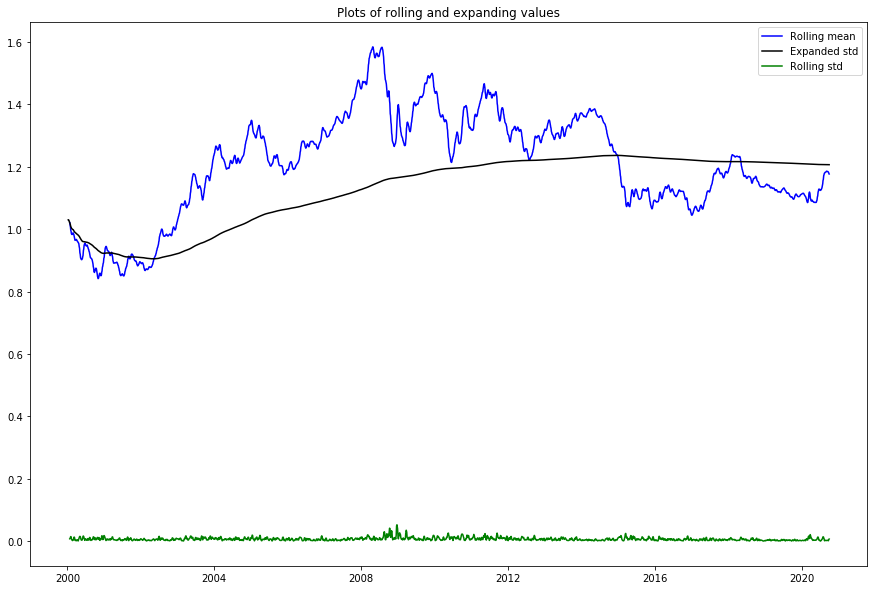

Dickey fuller results
Test statistics:  -1.9427239307978026
p-value:  0.31223687812079515
Number of lags used :  33
Number of observations used :  5345
critical value (1%%):  -3.431574030549211
critical value (5%%):  -2.862080896827635
critical value (10%%):  -2.567057918716162


In [11]:
moving_average_original = eur_usd_df['Last'].rolling(window = 5, center = False).mean()
moving_average_original = moving_average_original[5:]
transform_data_results(moving_average_original)

* TRANSFORMATION with difference between log data and first order difference of log data
* difference = log_data - log_data.shift()

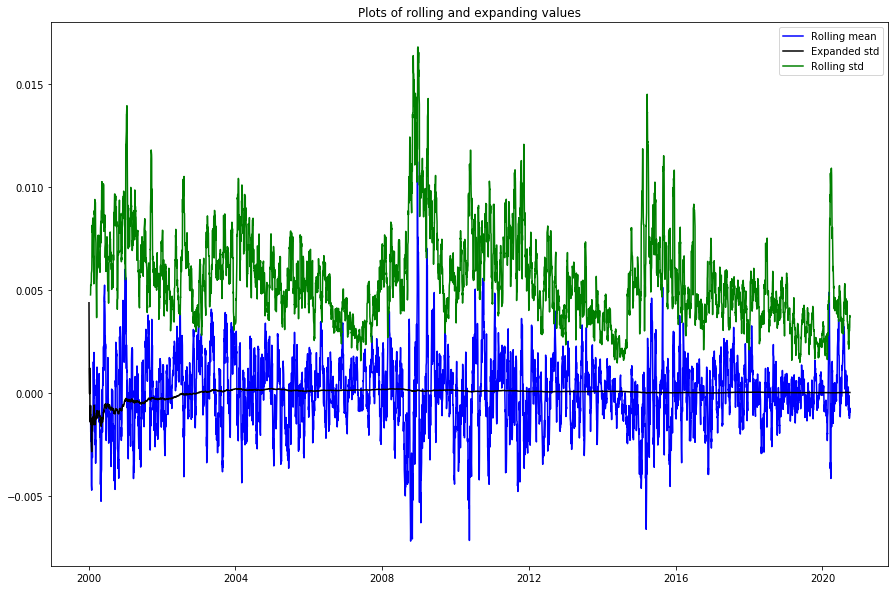

Dickey fuller results
Test statistics:  -73.9101291536764
p-value:  0.0
Number of lags used :  0
Number of observations used :  5382
critical value (1%%):  -3.4315656116048294
critical value (5%%):  -2.8620771772721496
critical value (10%%):  -2.5670559386705563


In [12]:
difference_log_data = log_data.diff(periods = 1)
difference_log_data = difference_log_data[1:]
transform_data_results(difference_log_data)

### Decomposion: trend, seasonality, residuals
* De-trending and de-seasonalizing made the data(i.e., the residuals). Based on the __Dickey-Fuller test__, the p value is less than 0.05, hence this concludes that the time series is stationary

<Figure size 432x288 with 0 Axes>

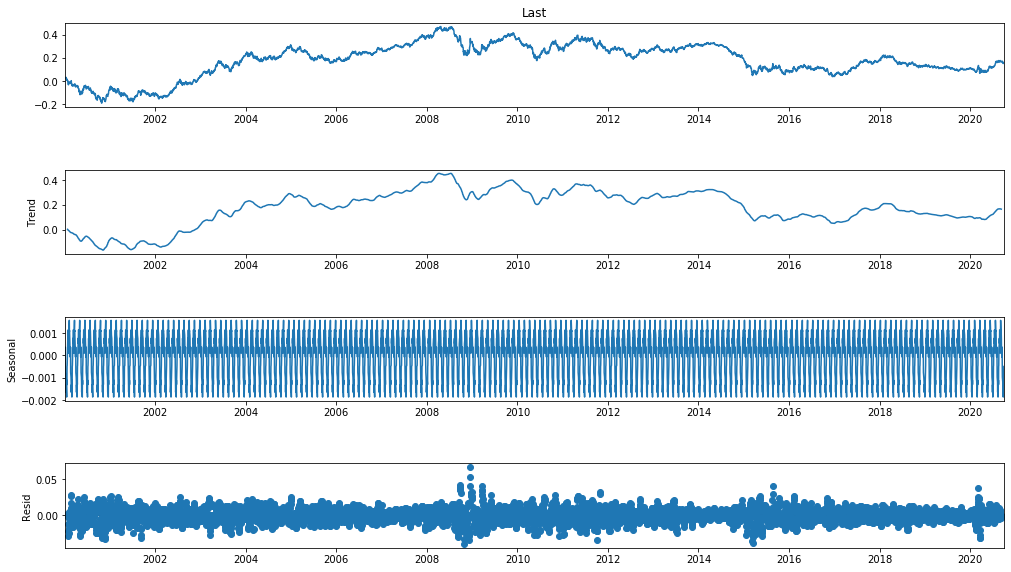

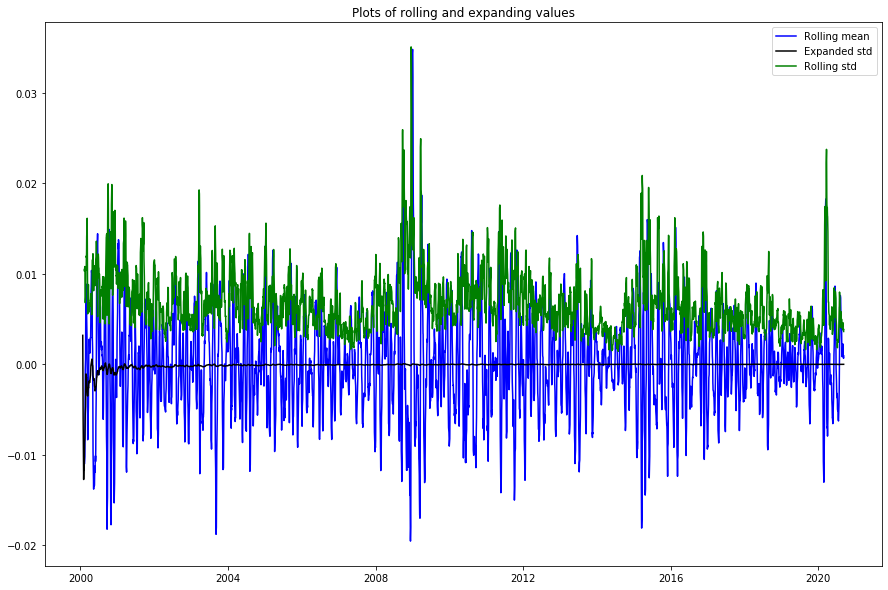

Dickey fuller results
Test statistics:  -18.26421570430346
p-value:  2.327403820836071e-30
Number of lags used :  31
Number of observations used :  5322
critical value (1%%):  -3.431579322976679
critical value (5%%):  -2.862083235058105
critical value (10%%):  -2.567059163436508


In [13]:
seasonal_result = seasonal_decompose(x = log_data,
                                     model = 'additive',
                                     freq = 30)
figure = plt.figure()
figure = seasonal_result.plot()
figure.set_size_inches(16, 9)
seasonal_result_resid = seasonal_result.resid.dropna()
transform_data_results(seasonal_result_resid)

## Models
### ARIMA Models
ARIMA = Auto-Regressive Integrated Moving Average
* This model assumes that the time series is stationary.

__Depends on:__

1. Number of Auto-regressive terms (p).
2. Number of Integrated or Difference terms (d)
3. Number of MA (moving average) terms (q)

#### ACF and PACF plots

* Values for p and q can be determined using ACF and PACF plots
* Autocorrelation Function(ACF) is the correlation between the time series with a lagged version of itself (example the correlation of Y(t) with Y(t-1)).
* Partial Autocorrelation function is explained by each successive lagged term.

Way to determine ACF and PACF plots?
* p - Lag value where PACF chart crosses the upper confidence interval for the first time
* q - Lag value where ACF chart crosses the upper condidence interval for the first time

In [14]:
from statsmodels.tsa.stattools import acf, pacf

In [15]:
lag_acf = acf(x = difference_log_data, nlags = 20)
lag_pacf = pacf(x = difference_log_data, nlags = 20)

In [16]:
def plot_acf_pacf(data):
    plt.plot(data)
    plt.axhline(y = 0, linestyle = '--', color = 'gray')
    plt.axhline(y = - 1.96 / len(data), linestyle = '--', color = 'gray')
    plt.axhline(y = 1.96 / len(data), linestyle = '--', color = 'gray')
    plt.show()

* Autocorrelation factor plot

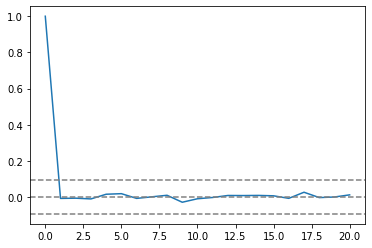

In [17]:
plot_acf_pacf(lag_acf)

* Partial Autocorrelation factor plot

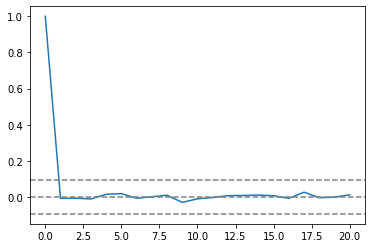

In [18]:
plot_acf_pacf(lag_pacf)

In [19]:
def run_arima_model(data, p, d, q):
    
#     fitting the ARIMA model
    model = ARIMA(endog = data, order = (p, d, q))
    results = model.fit(disp = -1)
    
    # get correct lengths
    len_results = len(results.fittedvalues)
    ts_modified = data[len_results:]
    
    # calculate the root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(data))
    
#   plots
    plt.plot(data)
    plt.plot(results.fittedvalues, color = 'red')
    plt.title('ARIMA model {} {} {} {} {}'.format(p, q, d, rss, rmse))
    plt.show()
    plt.close()
    
    return results

/home/arjun/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


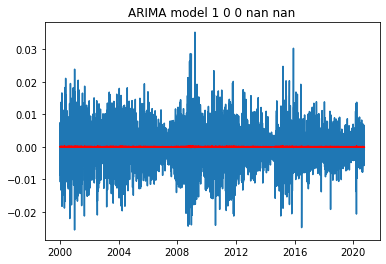

In [20]:
run_arima_model(data = difference_log_data,
                p = 1,
                d = 0,
                q = 0)

/home/arjun/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/arjun/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


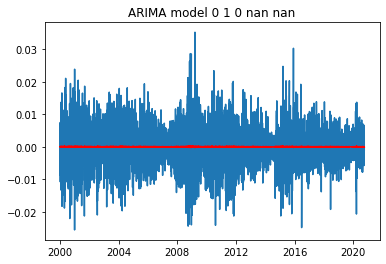

In [21]:
run_arima_model(data = difference_log_data,
                p = 0,
                d = 0,
                q = 1)

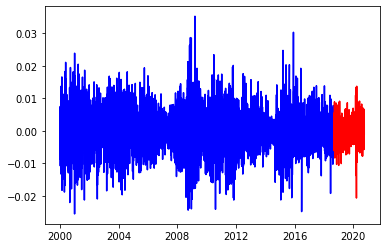

In [22]:
# split 90% training and 10% testing data
train_data, test_data = difference_log_data[:int(len(difference_log_data)*0.9)], difference_log_data[int(len(difference_log_data)*0.9):]
plt.plot(train_data, color = 'blue')
plt.plot(test_data, color= 'red')
plt.show()

#### Auto ARIMA
* This automatically discovers the optimal order for an ARIMA model and returns the fitted arima model.
* Autoarima functions works by conducting differencing tests (Kwiatkowski-Phillips-Schmidt-Shin, Augmented Dickey-Fuller or Phillis-Perron) to determine the order of differencing __d__ and then fitted models within ranges of __start_p, max_p, start_q, max_q__ ranges.
* If seasonal option is selected, autoarima also seeks to identify the optimal P, Q hyperparameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing D.

In [23]:
from pmdarima.arima import auto_arima

In [24]:
model_auto_arima = auto_arima(y = difference_log_data,
                              start_p = 0,
                              start_q = 0,
                              test = 'adf', #adf stands for augmented duckey fuller test to find optimal d value
                              max_p = 3,
                              max_q = 3,
                              m = 1, # frequency of series
                              d = None, # model to decide the value of d
                              seasonal = True, # no seasonality
                              start_P = 0,
                              D = 0,
                              trace = True,
                              error_action = 'ignore',
                              suppress_warnings = True, 
                              stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-39765.396, Time=0.77 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-39763.705, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-39763.709, Time=1.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-39767.303, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-39761.396, Time=0.90 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.774 seconds


In [25]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5383
Model:                        SARIMAX   Log Likelihood               19884.652
Date:                Mon, 05 Oct 2020   AIC                         -39767.303
Time:                        16:23:32   BIC                         -39760.712
Sample:                             0   HQIC                        -39765.002
                               - 5383                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.622e-05   5.15e-07     70.371      0.000    3.52e-05    3.72e-05
===================================================================================
Ljung-Box (Q):                       37.31   Jarque-Bera (JB):               634.15
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

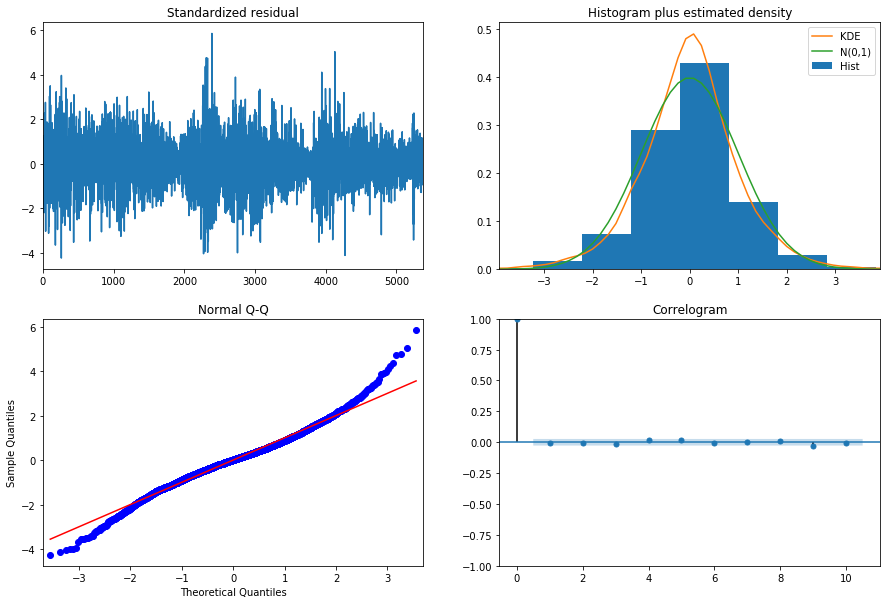

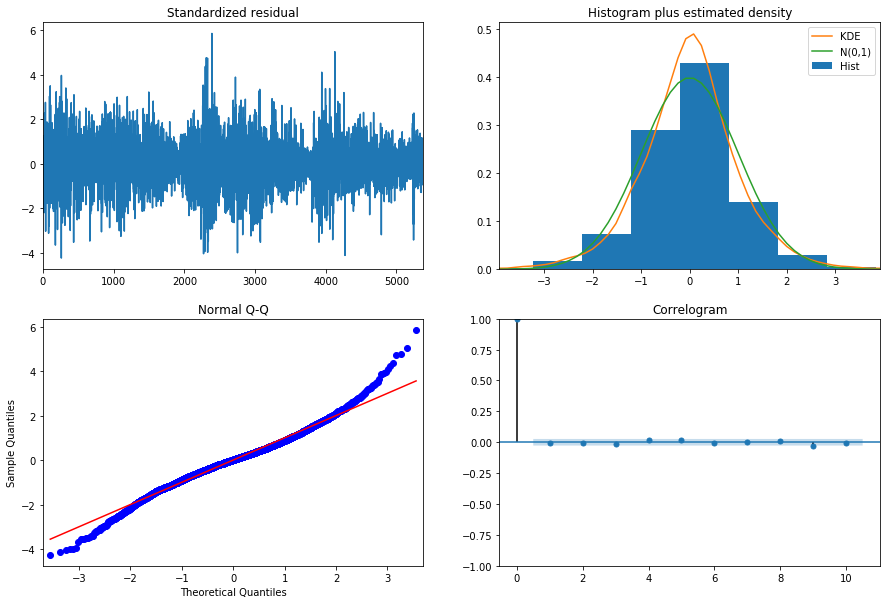

In [26]:
model_auto_arima.plot_diagnostics(figsize = (15,10))

In [27]:
arima_model = ARIMA(endog = train_data,
                    order = (0,0,0))
fitted_model = arima_model.fit(disp = -1)
fitted_model.summary()

/home/arjun/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Last   No. Observations:                 4844
Model:                     ARMA(0, 0)   Log Likelihood               17748.721
Method:                           css   S.D. of innovations              0.006
Date:                Mon, 05 Oct 2020   AIC                         -35493.442
Time:                        16:23:33   BIC                         -35480.471
Sample:                             0   HQIC                        -35488.888
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.539e-05   8.91e-05      0.285      0.776      -0.000       0.000
==============================================================================
"""

### Forecasting using ARIMA model

In [28]:
fc, se, conf = fitted_model.forecast(steps = len(test_data),
                                     alpha = 0.05) # 95% confidence

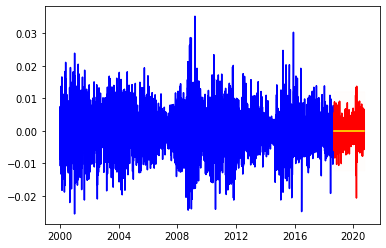

In [29]:
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:,0], index = test_data.index)
upper_series = pd.Series(conf[:,1], index = test_data.index)
plt.plot(train_data, color = 'blue', label = 'Training dataset')
plt.plot(test_data, color = 'red', label = 'Test dataset')
plt.plot(fc_series, color = 'yellow', label = 'Arima Prediction')
plt.fill_between(x = lower_series.index, 
                 y1 = lower_series, 
                 y2 = upper_series, 
                 color = 'orange', 
                 alpha = 0.01)
plt.show()

In [30]:
import math
print('MSE: {}'.format(mean_squared_error(y_true = test_data,
                                          y_pred = fc)))
print('MAE: {}'.format(mean_absolute_error(y_true = test_data,
                                          y_pred = fc)))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_true = test_data,
                                          y_pred = fc))))
mape = np.mean((np.abs(fc - test_data) )/ np.abs(test_data))


MSE: 1.6149449739656697e-05
MAE: 0.0030356835708282973
RMSE: 0.0040186377965246755
